# Model Analysis with Data from APOGEE DR17

In this notebook, you will explore the accuracy of model-generated age estimates by using data from APOGEE DR17 (read more at https://www.sdss4.org/dr17/irspec/) as compiled by the OCCAM Survey (https://ui.adsabs.harvard.edu/abs/2022AJ....164...85M/abstract). `Kiauhoku` (https://ui.adsabs.harvard.edu/abs/2020ascl.soft11027C/abstract) will be used to estimate the ages for four different model grids (YREC, DSEP, MIST, and GARSTEC) with parameters as described in Tayar et al. 2022 (https://ui.adsabs.harvard.edu/abs/2022ApJ...927...31T/abstract)

There are 4 parts to this notebook:
I. Reading and Organizing the Data
II. Getting the Age Estimates
III. Isochrones and Kiel Diagrams
IV. External Mass Comparison for M67

## Part I: Reading and Organizing the Data

The Open Cluster Chemical Analysis and Mapping (OCCAM) Survey data from Myers et al. 2022 can be obtained at https://www.sdss4.org/dr17/data_access/value-added-catalogs/?vac_id=open-cluster-chemical-abundances-and-mapping-catalog. These files have sorted stars into clusters. Download both occam_cluster-DR17.fits and occam_member-DR17.fits. These files do not contain the APOGEE values for effective temperature, [M/H], or surface gravity, which Kiauhoku uses to determine the age of a star. To get the rest of the data, download allStar-dr17-synspec_rev1.fits from https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/. 

In this section, we combine the data and save it as a separate file. This part is here as an example. The file is already saved in this project folder.

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, join

In [2]:
#load in the APOGEE DR17 data 
#in google colab you can get the file using
#!wget https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits 
#downloaded from https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits 

filepath = "allStar-dr17-synspec_rev1.fits" # (you will have to change this for wherever you downloaded your file)
apogee=Table.read(filepath, hdu=1)

# read in OCCAM clusters value added catalog
filepath = "occam_cluster-DR17.fits"
clusters=Table.read(filepath, format="fits")
clusters.add_index("NAME")
print(f'There are {len(clusters)} clusters')

#read in OCCAM clusters value added catalog
filepath = "occam_member-DR17.fits"
cluster_stars=Table.read(filepath, format="fits")

There are 153 clusters


In [4]:
# organize the data that is needed for Kiauhoku

# get the parameters from the OCCAM data that are needed
needed_cols = ['APOGEE_ID', "CLUSTER", "LOCATION_ID", "PM_PROB", "CG_PROB", "FEH_PROB", "RV_PROB", "FE_H"]

l = list(cluster_stars.columns)
for col in l:
    if col not in needed_cols:
        cluster_stars.remove_column(col)
l = list(cluster_stars.columns)
print(l)

['CLUSTER', 'APOGEE_ID', 'LOCATION_ID', 'FE_H', 'RV_PROB', 'FEH_PROB', 'PM_PROB', 'CG_PROB']


In [5]:
# get the parameters from the APOGEE DR17 data that are of interest
# TEFF, LOGG, and M_H are needed for Kiauhoku age estimation
# and you can add other variables you are interested in
needed_cols = ["APOGEE_ID", "CLUSTER", "TEFF", "LOGG", "M_H", "ALPHA_M", "LOCATION_ID"]
a = list(apogee.columns)
for col in a:
    if col not in needed_cols:
        apogee.remove_column(col)
print(list(apogee.columns))


['APOGEE_ID', 'LOCATION_ID', 'TEFF', 'LOGG', 'M_H', 'ALPHA_M']


In [6]:
all_data = join(apogee, cluster_stars, keys=["APOGEE_ID", "LOCATION_ID"])
all_data.add_index("CLUSTER")
# Remove rows that are missing crucial data
missing_TEFF = all_data["TEFF"].mask.nonzero()[0]
all_data.remove_rows(missing_TEFF)
missing_M_H = all_data["M_H"].mask.nonzero()[0]
all_data.remove_rows(missing_M_H)
missing_LOGG = all_data["LOGG"].mask.nonzero()[0]
all_data.remove_rows(missing_LOGG)


all_data.remove_column('LOCATION_ID')

# This data table has already been saved to 'occam_dr17_clusters.fits'
# all_data.write('occam_dr17_clusters.fits', format='fits')

In [7]:
# Warning: the cluster ASCC 19 has star 2M05312734-0340356 listed twice
all_data.add_index("APOGEE_ID")
ASCC19 = all_data.loc['CLUSTER', "ASCC 19"]
already_done = []
for ID in ASCC19['APOGEE_ID']:
    if (ID in already_done):
        print(ID)
        break
    else:
        already_done.append(ID)
ASCC19.loc['APOGEE_ID','2M05312734-0340356']

2M05312734-0340356


APOGEE_ID,TEFF,LOGG,M_H,ALPHA_M,CLUSTER,FE_H,RV_PROB,FEH_PROB,PM_PROB,CG_PROB
bytes30,float32,float32,float32,float32,bytes13,float64,float64,float64,float64,float64
2M05312734-0340356,3882.9526,4.6277785,0.18126,-0.0645037,ASCC 19,0.19,0.0,0.0,0.0,0.0
2M05312734-0340356,3874.9023,4.624039,0.17365,-0.0631077,ASCC 19,0.19,0.0,0.0,0.0,0.0


## Part II: Getting the Age Estimates

Select a cluster from the list, then use Kiauhoku (https://github.com/zclaytor/kiauhoku/tree/main) to get the ages of all the stars in the cluster. Warning: sometimes Kiauhoku causes the kernel to crash. The causes of this are unclear, but it occurs when some stars are fitted to some of the model grids. 

The *skip* dictionary in PartII.py has saved the APOGEE ID of kernel-crashing stars for M67 (NGC 2682), but I would recommend setting verbose=True when running this code for other clusters so that you can see which stars cause the kernel to crash and add them to the skip dictionary in clusters.py. If you plan to re-use the data, it will be much faster if you set writefile=True rather than re-running the code every time.

For my research note, I excluded stars which were poorly fitted to the model grids, stars with log(g) > 4.5, stars with a membership probability of 0 in any of the 4 categories, and stars with age estimates older than the age of the universe.

At the end of this section, there is a chance to plot the stars on a Kiel diagram for the different models, and plot age estimates as a function of surface gravity

In [1]:
import PartII
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import unique
import statsmodels.api as sm

The main function in PartII.py is ```get_cluster_table```

```get_cluster_table(cluster_name, writefile=False, verbose=False)```

```cluster_name``` (str): the name of the cluster as it is listed in the OCCAM database. 
    
```writefile (default False)``` (bool): Writes the table to f'{cluster_name}.fits'. If you are running this for a larger cluster, it is recommended that you set writefile=True, as get_models_table takes a long time to run. If the file has already been generated for the cluster, this will have no effect.
    
```verbose (default False)``` (bool): If ```True```, the function out statements as the model runs. If you are running a cluster for the first time and it is not included in ```PartII.skip```, it is recommended that you set ```verbose=True```, as the kernel may crash for certain stars. You will have to manually add those to ```PartII.skip```

In [3]:
cluster = PartII.get_cluster_table("NGC 2682", verbose=True)

# cluster has each star saved 4 times, once for each model
# we can get the number of stars in the cluster by looking at the number of unique IDs
u = unique(cluster, 'ID')
print('Number of cluster stars per model:', len(u))
table = cluster[cluster['err'] == 0]
unique_table = unique(table, 'ID')
print('Number of cluster stars that fit well to a model grid:', len(unique_table))
table = table[abs(table['RV_PROB']) > 0]
table = table[abs(table['FEH_PROB']) > 0]
table = table[abs(table['CG_PROB']) > 0]
table = table[abs(table['PM_PROB']) > 0]
unique_table = unique(table, 'ID')
print('Number of stars with all types of membership probability > 0:', len(unique_table))
table = table[table['age'] < 13.7]

logg_limit = 4.5
cleaned_cluster = table[table['LOGG'] < logg_limit]
unique_cleaned_cluster = unique(table, 'ID')
print('Number of stars with logg < 4.5:', len(unique_cleaned_cluster))


# now split the table into the 4 model grids
yrec, dsep, mist, gars = PartII.get_model_tables(cleaned_cluster)


NGC 2682 has a pre-made table, nice!
Number of cluster stars per model: 608
Number of cluster stars that fit well to a model grid: 540
Number of stars with all types of membership probability > 0: 297
Number of stars with logg < 4.5: 270


In [6]:
print(len(yrec), len(dsep), len(mist), len(gars))

#compare the average ages (in Gyr) for each model
print("yrec: ", yrec['age'].mean())
print("dsep: ", dsep['age'].mean())
print("mist: ", mist['age'].mean())
print("garstec: ", gars['age'].mean())

print("Model-wide average", cleaned_cluster['age'].mean())


140 141 143 140
yrec:  5.742390853542968
dsep:  4.716792843123637
mist:  4.837225081419541
garstec:  4.848739659485153
Model-wide average 5.0346617896229855


You now have a table, `cluster` with the following information for each star in your cluster:
- Estimated age, mass, equivalent evolutionary phase (eep), temperature, and luminosity for the models
- "err" flag to indicate if the star converged to the model grid within the specified tolerance of 1e-6
- APOGEE ID, surface gravity, effective temperature, [M/H], and whatever else you decided to include
- OCCAM cluster membership probability in 4 categories: Fe/H, proper motion, radial velocity, and from Cantat-Gaudin et al. (1994)

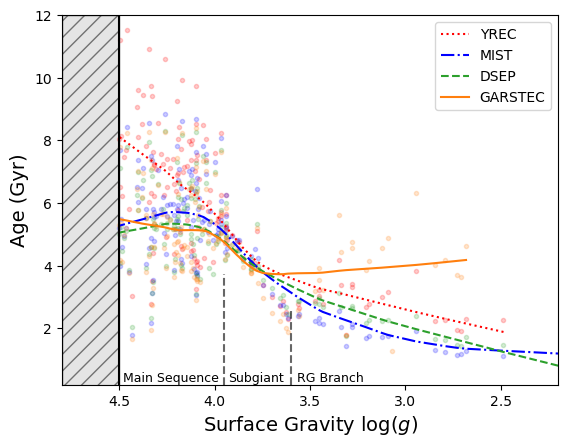

In [7]:
# scatter plot of age vs surface gravity
a = .2
plt.scatter(yrec['LOGG'],yrec['age'], color='r', alpha=a, marker='.')
plt.scatter(mist['LOGG'],mist['age'], color='b', alpha=a, marker='.')
plt.scatter(dsep['LOGG'],dsep['age'], color='tab:green', alpha=a, marker='.')
plt.scatter(gars['LOGG'],gars['age'], color='tab:orange', alpha=a, marker='.')

y = yrec.to_pandas().sort_values(by="LOGG")
m = mist.to_pandas().sort_values(by="LOGG")
d = dsep.to_pandas().sort_values(by="LOGG")
g = gars.to_pandas().sort_values(by="LOGG")

"""
LOWESS trendlines offer qualitative insight into the 
relationship between age estimates and surface gravity
for each model
"""
y_trendline = sm.nonparametric.lowess(y['age'], y['LOGG'])
m_trendline = sm.nonparametric.lowess(m['age'], m['LOGG'])
d_trendline = sm.nonparametric.lowess(d['age'], d['LOGG'])
g_trendline = sm.nonparametric.lowess(g['age'], g['LOGG'])

plt.plot(y['LOGG'], y_trendline[:, 1], color='r', label="YREC", linestyle='dotted')
plt.plot(m['LOGG'], m_trendline[:, 1], color='b', label="MIST", linestyle='dashdot')
plt.plot(d['LOGG'], d_trendline[:, 1], color='tab:green', label="DSEP", linestyle='dashed')
plt.plot(g['LOGG'], g_trendline[:, 1], color='tab:orange', label="GARSTEC", linestyle='solid')

plt.xlabel(r'Surface Gravity log($\it{g}$)', size=14)
plt.ylabel("Age (Gyr)", size=14)
ax = plt.gca()
ax.invert_xaxis()
plt.xlim(4.8,2.2)
plt.ylim(0.2,12)
ax.legend()

# divide the graph into sections
ax.axvline(3.6, 0, .2 , linestyle='--', color='k', alpha=.6)
ax.axvline(3.95, 0, .3, linestyle='--', color='k', alpha=.6)
ax.text(4.48,.3,r'Main Sequence',size=9)
ax.text(3.93,.3,r'Subgiant',size=9)
ax.text(3.57,.3,r'RG Branch',size=9)

# add shaded area to indicate where we blocked off high surface gravity values
plt.axvline(logg_limit, color='k')
plt.axvspan(4.8,logg_limit, color='k', alpha=.1)
plt.fill_between([4.8,logg_limit], 0, 12, facecolor="none", hatch="//", edgecolor="k", alpha=.5)

plt.show()

You can plot a Kiel diagram (surface gravity vs temperature) colored by age and with your choice of model.

HR diagrams are more common than Kiel diagrams, but surface gravity, log(*g*), was used to estimate the ages of the star and we want to be consistent with which variable we are using

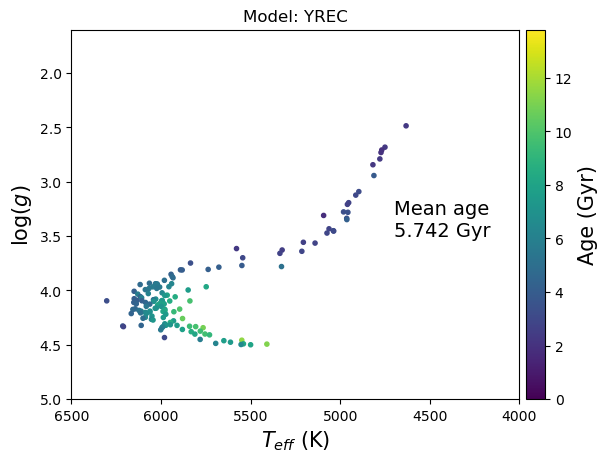

In [8]:
# pick a model and set the model_name to create a different Kiel diagram
model_data = y
model_name = "YREC"
ax1 = plt.axes([0.1, 0.11, 0.7, .77]) # make a custom axis so that you can control how the figure is saved
ax1.set_title(F'Model: {model_name}')

plot = ax1.scatter(model_data['TEFF'], model_data['LOGG'], c=model_data['age'], cmap="viridis", marker='.', vmin=0, vmax=13.8)
ax1.invert_xaxis()
ax1.invert_yaxis()

sub_ax = plt.axes([0.81, 0.11, 0.03, .77]) # add a small custom axis
cb = plt.colorbar(mappable=plot, label='Age (Gyr)', cax=sub_ax)
cb.set_label(label='Age (Gyr)',size=15)
ax1.set_xlabel(r'$T_{eff}$ (K)', size=15)
ax1.set_ylabel(r'log($g$)', size=15)

ax1.text(4700,3.25,r'Mean age', horizontalalignment='left', verticalalignment='center', size=14)
mean_age = model_data['age'].mean()
ax1.text(4700,3.5,f'{mean_age:.3f} Gyr',size=14)
plt.setp(ax1, xlim=(6500,4000), ylim=(5,1.6))
# plt.savefig(f'{model_name}.eps', format='eps')
plt.show()

## Part III: Isochrones and Kiel Diagrams

`Kiauhoku` can be used to generate isochrones for different ages and metallicities. See `Isochrones.ipynb`and `PartIII.py` for more details.

The generated isochrones can be added to the Kiel diagrams. The next cell has the same code as the final cell in `Section II`, but with isochrones added.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import unique
import PartII

In [13]:
cluster = PartII.get_cluster_table("NGC 2682", verbose=False)

# cluster has each star saved 4 times, once for each model
# we can get the number of stars in the cluster by looking at the number of unique IDs
u = unique(cluster, 'ID')
table = cluster[cluster['err'] == 0]
unique_table = unique(table, 'ID')
table = table[abs(table['RV_PROB']) > 0]
table = table[abs(table['FEH_PROB']) > 0]
table = table[abs(table['CG_PROB']) > 0]
table = table[abs(table['PM_PROB']) > 0]
unique_table = unique(table, 'ID')
table = table[table['age'] < 13.7]

logg_limit = 4.5
cleaned_cluster = table[table['LOGG'] < logg_limit]
unique_cleaned_cluster = unique(table, 'ID')

# split the table into the 4 model grids
yrec, dsep, mist, gars = PartII.get_model_tables(cleaned_cluster)
y = yrec.to_pandas().sort_values(by="LOGG")
m = mist.to_pandas().sort_values(by="LOGG")
d = dsep.to_pandas().sort_values(by="LOGG")
g = gars.to_pandas().sort_values(by="LOGG")

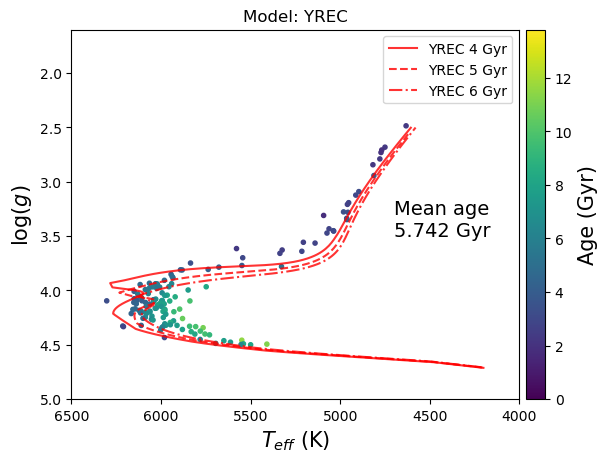

In [14]:
# Here we plot a Kiel diagram (surface gravity vs temperature)
# colored by age and with your choice of model
# HR diagrams are more commonly used than Kiel diagrams, but
# LOGG was used to estimate the ages of the star and we want to be consistent

# the model and model_name can be changed
model_data = y
model_name = "YREC"
colors = {'YREC':"r", "MIST":'b', "DSEP":'tab:green', 'GARSTEC':'tab:orange'}
color = colors[model_name]

ax1 = plt.axes([0.1, 0.11, 0.7, .77]) # make a custom axis so that you can control how the figure is saved

model4 = pd.read_csv(f'isochrones/{model_name}4_FEH=0').set_index('Unnamed: 0')
teffs4 = np.array(model4["teff"])
loggs4 = np.array(model4["logg"])
ax1.plot(teffs4,loggs4, '-', alpha=.8, color=color, label=f'{model_name} 4 Gyr')

model5 = pd.read_csv(f'isochrones/{model_name}5_FEH=0').set_index('Unnamed: 0')
teffs5 = np.array(model5["teff"])
loggs5 = np.array(model5["logg"])
ax1.plot(teffs5,loggs5, '--', alpha=.8, color=color, label=f'{model_name} 5 Gyr')

model6 = pd.read_csv(f'isochrones/{model_name}6_FEH=0').set_index('Unnamed: 0')
teffs6 = np.array(model6["teff"])
loggs6 = np.array(model6["logg"])
ax1.plot(teffs6,loggs6, '-.', alpha=.8, color=color, label=f'{model_name} 6 Gyr')

ax1.set_title(F'Model: {model_name}')

plot = ax1.scatter(model_data['TEFF'], model_data['LOGG'], c=model_data['age'], cmap="viridis", marker='.', vmin=0, vmax=13.8)
ax1.invert_xaxis()
ax1.invert_yaxis()

sub_ax = plt.axes([0.81, 0.11, 0.03, .77]) # add a small custom axis
cb = plt.colorbar(mappable=plot, label='Age (Gyr)', cax=sub_ax)
cb.set_label(label='Age (Gyr)',size=15)

ax1.set_xlabel(r'$T_{eff}$ (K)', size=15)
ax1.set_ylabel(r'log($g$)', size=15)
ax1.legend()
ax1.text(4700,3.25,r'Mean age', horizontalalignment='left', verticalalignment='center', size=14)
mean_age = model_data['age'].mean()
ax1.text(4700,3.5,f'{mean_age:.3f} Gyr',size=14)
plt.setp(ax1, xlim=(6500,4000), ylim=(5,1.6))
# plt.savefig(f'{model_name}.eps', format='eps')
plt.show()

## Part IV: External Mass Comparison for M67

Stello et al. 2016 (https://ui.adsabs.harvard.edu/abs/2016ApJ...832..133S/abstract) used asteroseismology to estimate the masses of red giants in M67. We will use this external contraint to further compare the models. We will plot the mass of red giants as a function of surface gravity. Stello et al. focused on M67 stars, so this code cannot be run for any other open cluster.

In [5]:
import numpy as np
import pandas as pd
import PartII
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
stello = pd.read_csv('stello.csv')
M67 = PartII.get_cluster_table("NGC 2682")
# clean up the table
table = M67[M67['err'] == 0]
table = table[abs(table['RV_PROB']) > 0]
table = table[abs(table['FEH_PROB']) > 0]
table = table[abs(table['CG_PROB']) > 0]
table = table[abs(table['PM_PROB']) > 0]
table = table[abs(table['age']) < 13.7]
logg_limit = 4.5
M67 = table[table['LOGG'] < logg_limit]

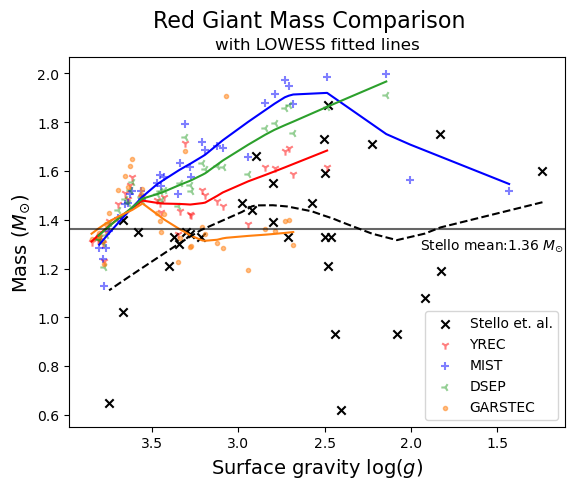

In [6]:
a = M67.to_pandas()
a = a.reset_index()
a['model'] = a['model'].astype(str)

yrec = a[a['model']=='yrec']
mist = a[a['model']=='mist']
dart = a[a['model']=='dart']
gars = a[a['model']=='gars']

yrec = yrec.sort_values(by="LOGG")[:35]
mist = mist.sort_values(by="LOGG")[:35]
dart = dart.sort_values(by="LOGG")[:35]
gars = gars.sort_values(by="LOGG")[:35]
stello = stello.sort_values(by="LOGG")
y_line = sm.nonparametric.lowess(yrec['mass'], yrec['LOGG'])
m_line = sm.nonparametric.lowess(mist['mass'], mist['LOGG'])
d_line = sm.nonparametric.lowess(dart['mass'], dart['LOGG'])
g_line = sm.nonparametric.lowess(gars['mass'], gars['LOGG'])
s_line = sm.nonparametric.lowess(stello['M corr'], stello['LOGG'])

plt.plot(yrec['LOGG'], y_line[:, 1], color="r")
plt.plot(mist['LOGG'], m_line[:, 1], color="b")
plt.plot(dart['LOGG'], d_line[:, 1], color="tab:green")
plt.plot(gars['LOGG'], g_line[:, 1], color="tab:orange")
plt.plot(stello['LOGG'][:-1], s_line[:, 1], '--', color='black')

plt.scatter(stello['LOGG'], stello['M corr'], marker='x', color='black', label='Stello et. al.')
plt.scatter(yrec['LOGG'][:35], yrec['mass'][:35], marker='1', color="r", label='YREC', alpha=.5)
plt.scatter(mist['LOGG'][:35], mist['mass'][:35], marker='+', color="b", label='MIST', alpha=.5)
plt.scatter(dart['LOGG'][:35], dart['mass'][:35], marker='3', color="tab:green", label='DSEP', alpha=.5)
plt.scatter(gars['LOGG'][:35], gars['mass'][:35], marker='.', color="tab:orange", label='GARSTEC', alpha=.5)
plt.axhline(y=1.36, color='black', alpha=.6)
plt.gca().annotate(r'Stello mean:1.36 $M_{\odot}$', (1.95,1.28))

plt.suptitle("Red Giant Mass Comparison", size=16)
plt.title("with LOWESS fitted lines")
plt.xlabel(r'Surface gravity log($\it{g}$)', size=14)
plt.ylabel(r'Mass ($M_{\odot}$)', size=14)
ax = plt.gca()
ax.invert_xaxis()
ax.legend()
# plt.savefig('RGMass.png', format='png')
plt.show()